# Introduction

#### This notebook will aim to analyze the interaction of Federal Funds Rate set during every Federal Open Market Commitee (FOMC) meeting, with the Standards and Poors 500 (S&P500) index. <br> The S&P500 Index was chosen to help demonstrate the interaction with majority of the stock market. The notebook will observe the effect of changing interests rate on the market, and if different sentiments (hawkish, doveish, hold) affect the stock market differently. <br>

### Section 1: Import and Prepare Data for Analysis <br>

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime 


In [2]:
fedrates = pd.read_excel("FedFunds.xlsx")

In [3]:
fedrates.head()

,Date,Rate
0,1954-07-01,0.80
1,1954-08-01,1.22
2,1954-09-01,1.06
3,1954-10-01,0.85
4,1954-11-01,0.83


In [4]:
fedrates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 788 entries, 0 to 787
Data columns (total 2 columns):
Date    788 non-null datetime64[ns]
Rate    788 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 12.4 KB


In [5]:
feddates = pd.read_excel("FOMCDates.xlsx")

In [6]:
feddates.head()

,begdate,scheduled,document,url
0,1954-09-22,1,Record of Policy Actions (115 KB PDF),/monetarypolicy/files/fomcropa19540922.pdf
1,1954-12-07,1,Record of Policy Actions (205 KB PDF),/monetarypolicy/files/fomcropa19541207.pdf
2,1955-01-11,1,Record of Policy Actions (220 KB PDF),/monetarypolicy/files/fomcropa19550111.pdf
3,1955-03-02,1,Record of Policy Actions (343 KB PDF),/monetarypolicy/files/fomcropa19550302.pdf
4,1955-05-10,1,Record of Policy Actions (238 KB PDF),/monetarypolicy/files/fomcropa19550510.pdf


In [7]:
feddates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 4 columns):
begdate      858 non-null datetime64[ns]
scheduled    858 non-null int64
document     810 non-null object
url          766 non-null object
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 26.9+ KB


In [8]:
feddates = feddates.drop(['document','url'],axis=1)

#### Since both date fields are already datetime format, we can split it by month and year and merge the two datasets and then drop the date column from fedrates since it is monthly data <br>

In [9]:
fedrates['month'] = fedrates['Date'].dt.month
feddates['month'] = feddates['begdate'].dt.month

fedrates['year'] = fedrates['Date'].dt.year
feddates['year'] = feddates['begdate'].dt.year

In [10]:
feddates.head()

,begdate,scheduled,month,year
0,1954-09-22,1,9,1954
1,1954-12-07,1,12,1954
2,1955-01-11,1,1,1955
3,1955-03-02,1,3,1955
4,1955-05-10,1,5,1955


In [11]:
fedrates.head()

,Date,Rate,month,year
0,1954-07-01,0.80,7,1954
1,1954-08-01,1.22,8,1954
2,1954-09-01,1.06,9,1954
3,1954-10-01,0.85,10,1954
4,1954-11-01,0.83,11,1954


In [12]:
fed_funds_data = feddates.merge(fedrates, on=['month','year'])

In [13]:
fed_funds_data.head(10)

,begdate,scheduled,month,year,Date,Rate
0,1954-09-22,1,9,1954,1954-09-01,1.06
1,1954-12-07,1,12,1954,1954-12-01,1.28
2,1955-01-11,1,1,1955,1955-01-01,1.39
3,1955-03-02,1,3,1955,1955-03-01,1.35
4,1955-05-10,1,5,1955,1955-05-01,1.43
5,1955-06-22,1,6,1955,1955-06-01,1.64
6,1955-07-12,1,7,1955,1955-07-01,1.68
7,1955-08-02,1,8,1955,1955-08-01,1.96
8,1955-08-23,1,8,1955,1955-08-01,1.96
9,1955-09-14,1,9,1955,1955-09-01,2.18


In [14]:
fed_funds_data.drop(['month','year','Date'],axis=1,inplace=True)

In [15]:
fed_funds_data.columns = ['MeetingDate', 'WasScheduled?', 'DecidedRate']

In [16]:
fed_funds_data['PreviousRate'] = fed_funds_data['DecidedRate'].shift(1,axis=0)

In [17]:
fed_funds_data['NextRate'] = fed_funds_data['DecidedRate'].shift(-1, axis=0)

In [18]:
fed_funds_data.head()

,MeetingDate,WasScheduled?,DecidedRate,PreviousRate,NextRate
0,1954-09-22,1,1.06,NaN,1.28
1,1954-12-07,1,1.28,1.06,1.39
2,1955-01-11,1,1.39,1.28,1.35
3,1955-03-02,1,1.35,1.39,1.43
4,1955-05-10,1,1.43,1.35,1.64


In [19]:
SP500 = pd.read_excel("SP500Data.xlsx")

In [20]:
SP500.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1954-01-04,24.950001,24.950001,24.950001,24.950001,24.950001,1310000
1,1954-01-05,25.100000,25.100000,25.100000,25.100000,25.100000,1520000
2,1954-01-06,25.139999,25.139999,25.139999,25.139999,25.139999,1460000
3,1954-01-07,25.059999,25.059999,25.059999,25.059999,25.059999,1540000
4,1954-01-08,24.930000,24.930000,24.930000,24.930000,24.930000,1260000


In [88]:
sns.set(rc={'figure.figsize':(44,36)})

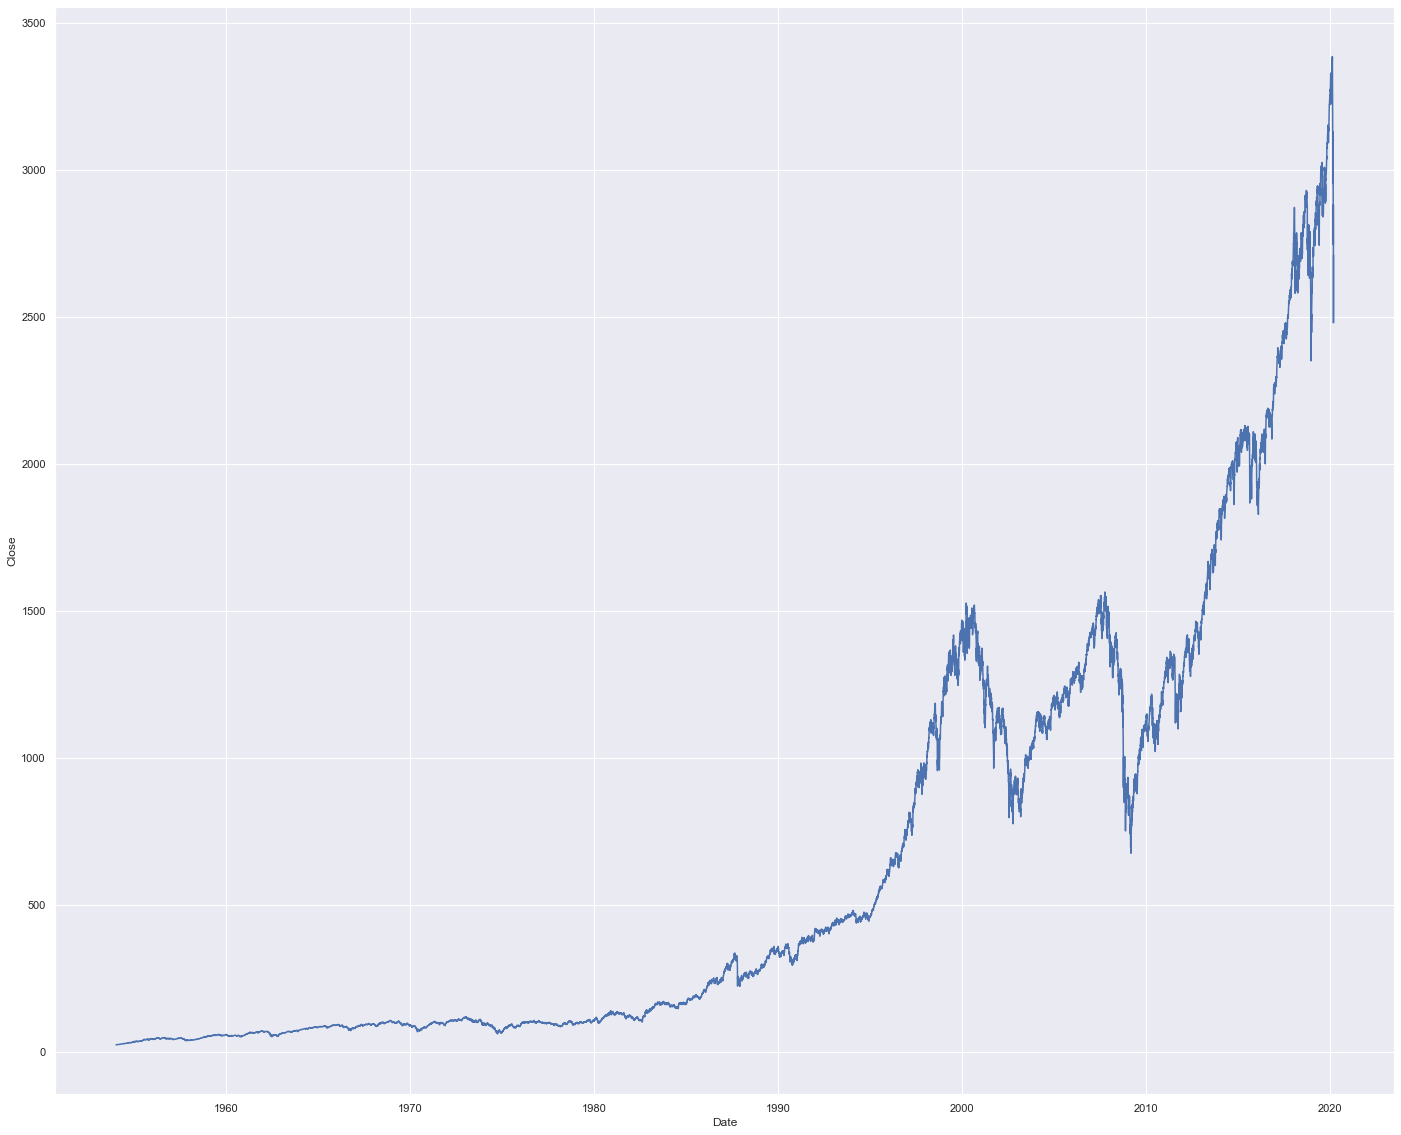

In [55]:
ax1= sns.lineplot(x='Date', y='Close', data=SP500)

### Section 2: Process Dataset<br>

In [23]:
def find_sentiment(data):
    if (data['DecidedRate'] >  data['PreviousRate']) & (data['DecidedRate']- data['PreviousRate'] > 0.15):
        return 'Hawkish'
    elif (data['DecidedRate'] < data['PreviousRate']) & (data['PreviousRate'] - data['DecidedRate'] > 0.15):
        return 'Doveish'
    elif (data['DecidedRate'] - data['NextRate'] > 0.15:
        return 'Hold-Doveish'
    elif (data['NextRate'] - data['DecidedRate'] >  0.15):
        return 'Hold-Hawkish'
    else:
        return 'Hold'
    

In [24]:
fed_funds_data['Sentiment'] = fed_funds_data.apply(find_sentiment, axis=1)

In [25]:
fed_funds_data['Sentiment'].value_counts()

Hawkish         200
Hold-Hawkish    194
Doveish         167
Hold-Doveish    163
Hold            132
Name: Sentiment, dtype: int64

In [26]:
fed_funds_data.head()

,MeetingDate,WasScheduled?,DecidedRate,PreviousRate,NextRate,Sentiment
0,1954-09-22,1,1.06,NaN,1.28,Hold-Hawkish
1,1954-12-07,1,1.28,1.06,1.39,Hawkish
2,1955-01-11,1,1.39,1.28,1.35,Hawkish
3,1955-03-02,1,1.35,1.39,1.43,Hold-Hawkish
4,1955-05-10,1,1.43,1.35,1.64,Hold-Hawkish


Hawkish    343 <br>
Doveish    275 <br>
Hold       238 <br>

In [101]:
SP500['MaxShift'] = (SP500['High'] - SP500['Low'])/SP500['Open']*100
SP500['DailyVolatility'] = (SP500['Open'] - SP500['Close'])/SP500['Open']*100

In [102]:
SP500['MaxShift'].describe()

count    16664.000000
mean         1.231540
std          0.917670
min          0.000000
25%          0.630034
50%          1.176178
75%          1.683046
max         20.470466
Name: MaxShift, dtype: float64

In [103]:
SP500['DailyVolatility'].describe()

count    16664.000000
mean        -0.025019
std          0.914612
min        -10.789006
25%         -0.416123
50%          0.000000
75%          0.327057
max         20.466931
Name: DailyVolatility, dtype: float64

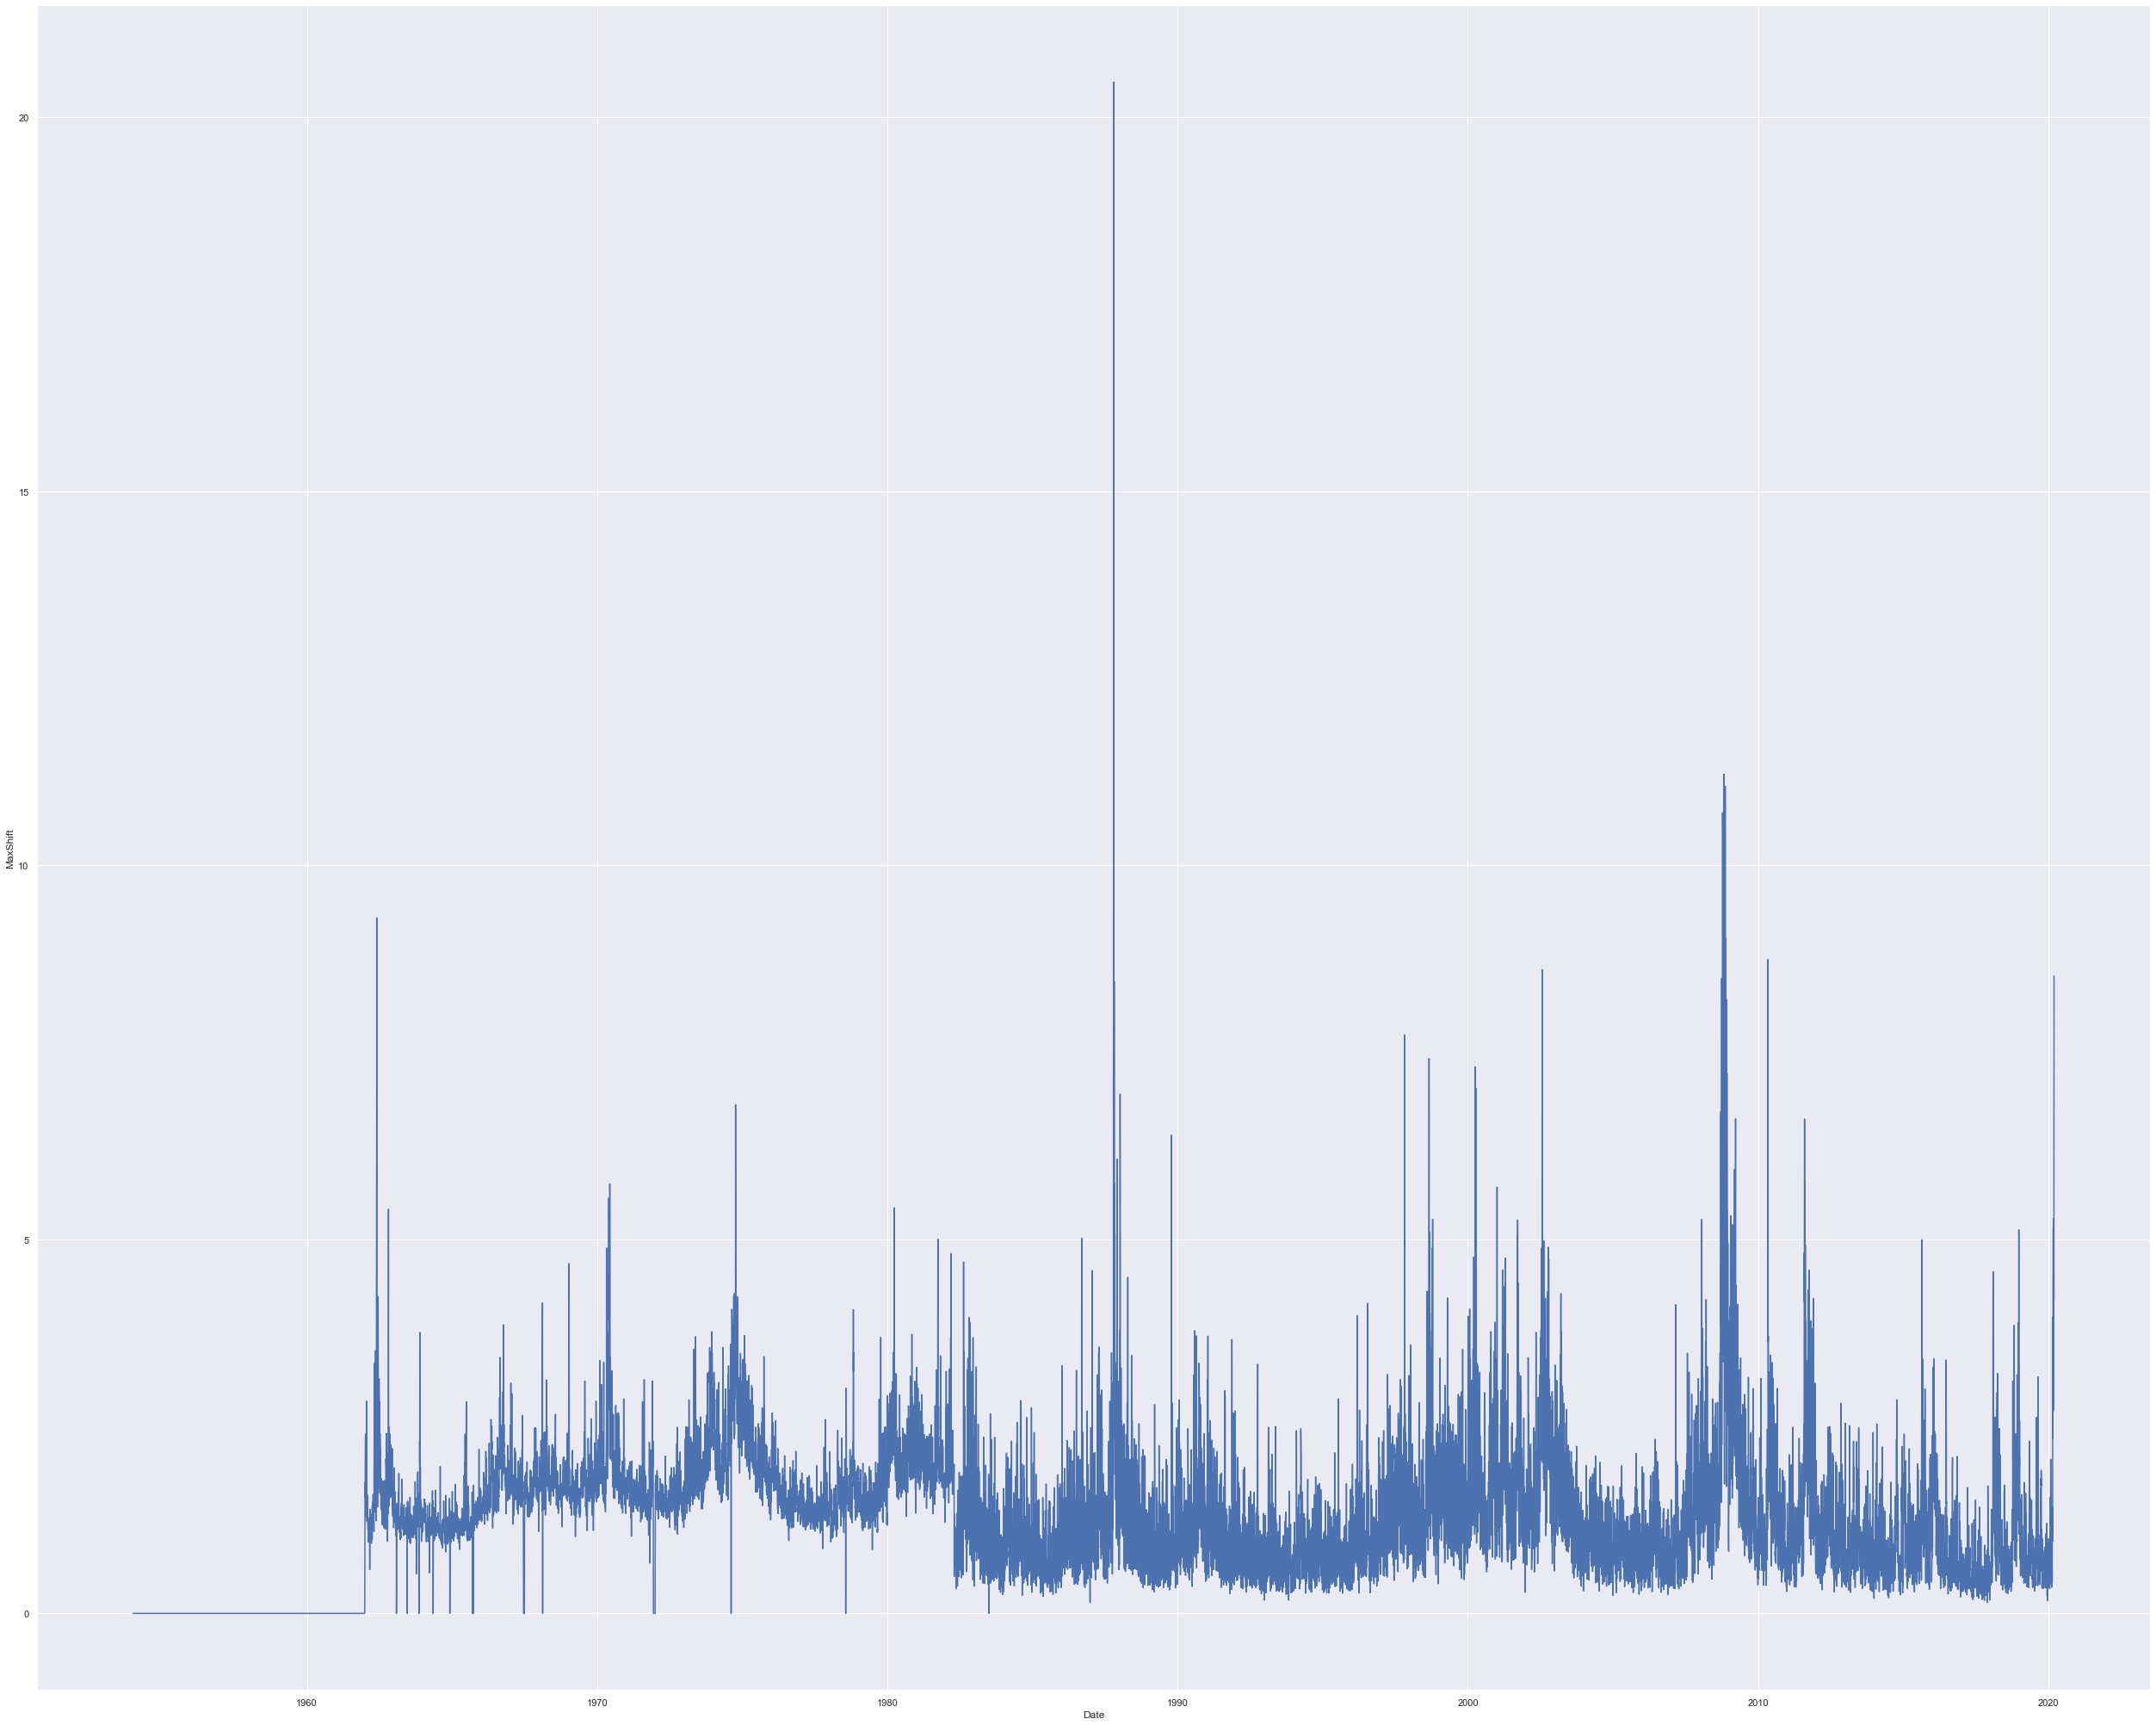

In [104]:
sns.lineplot(x='Date', y='MaxShift', data=SP500)

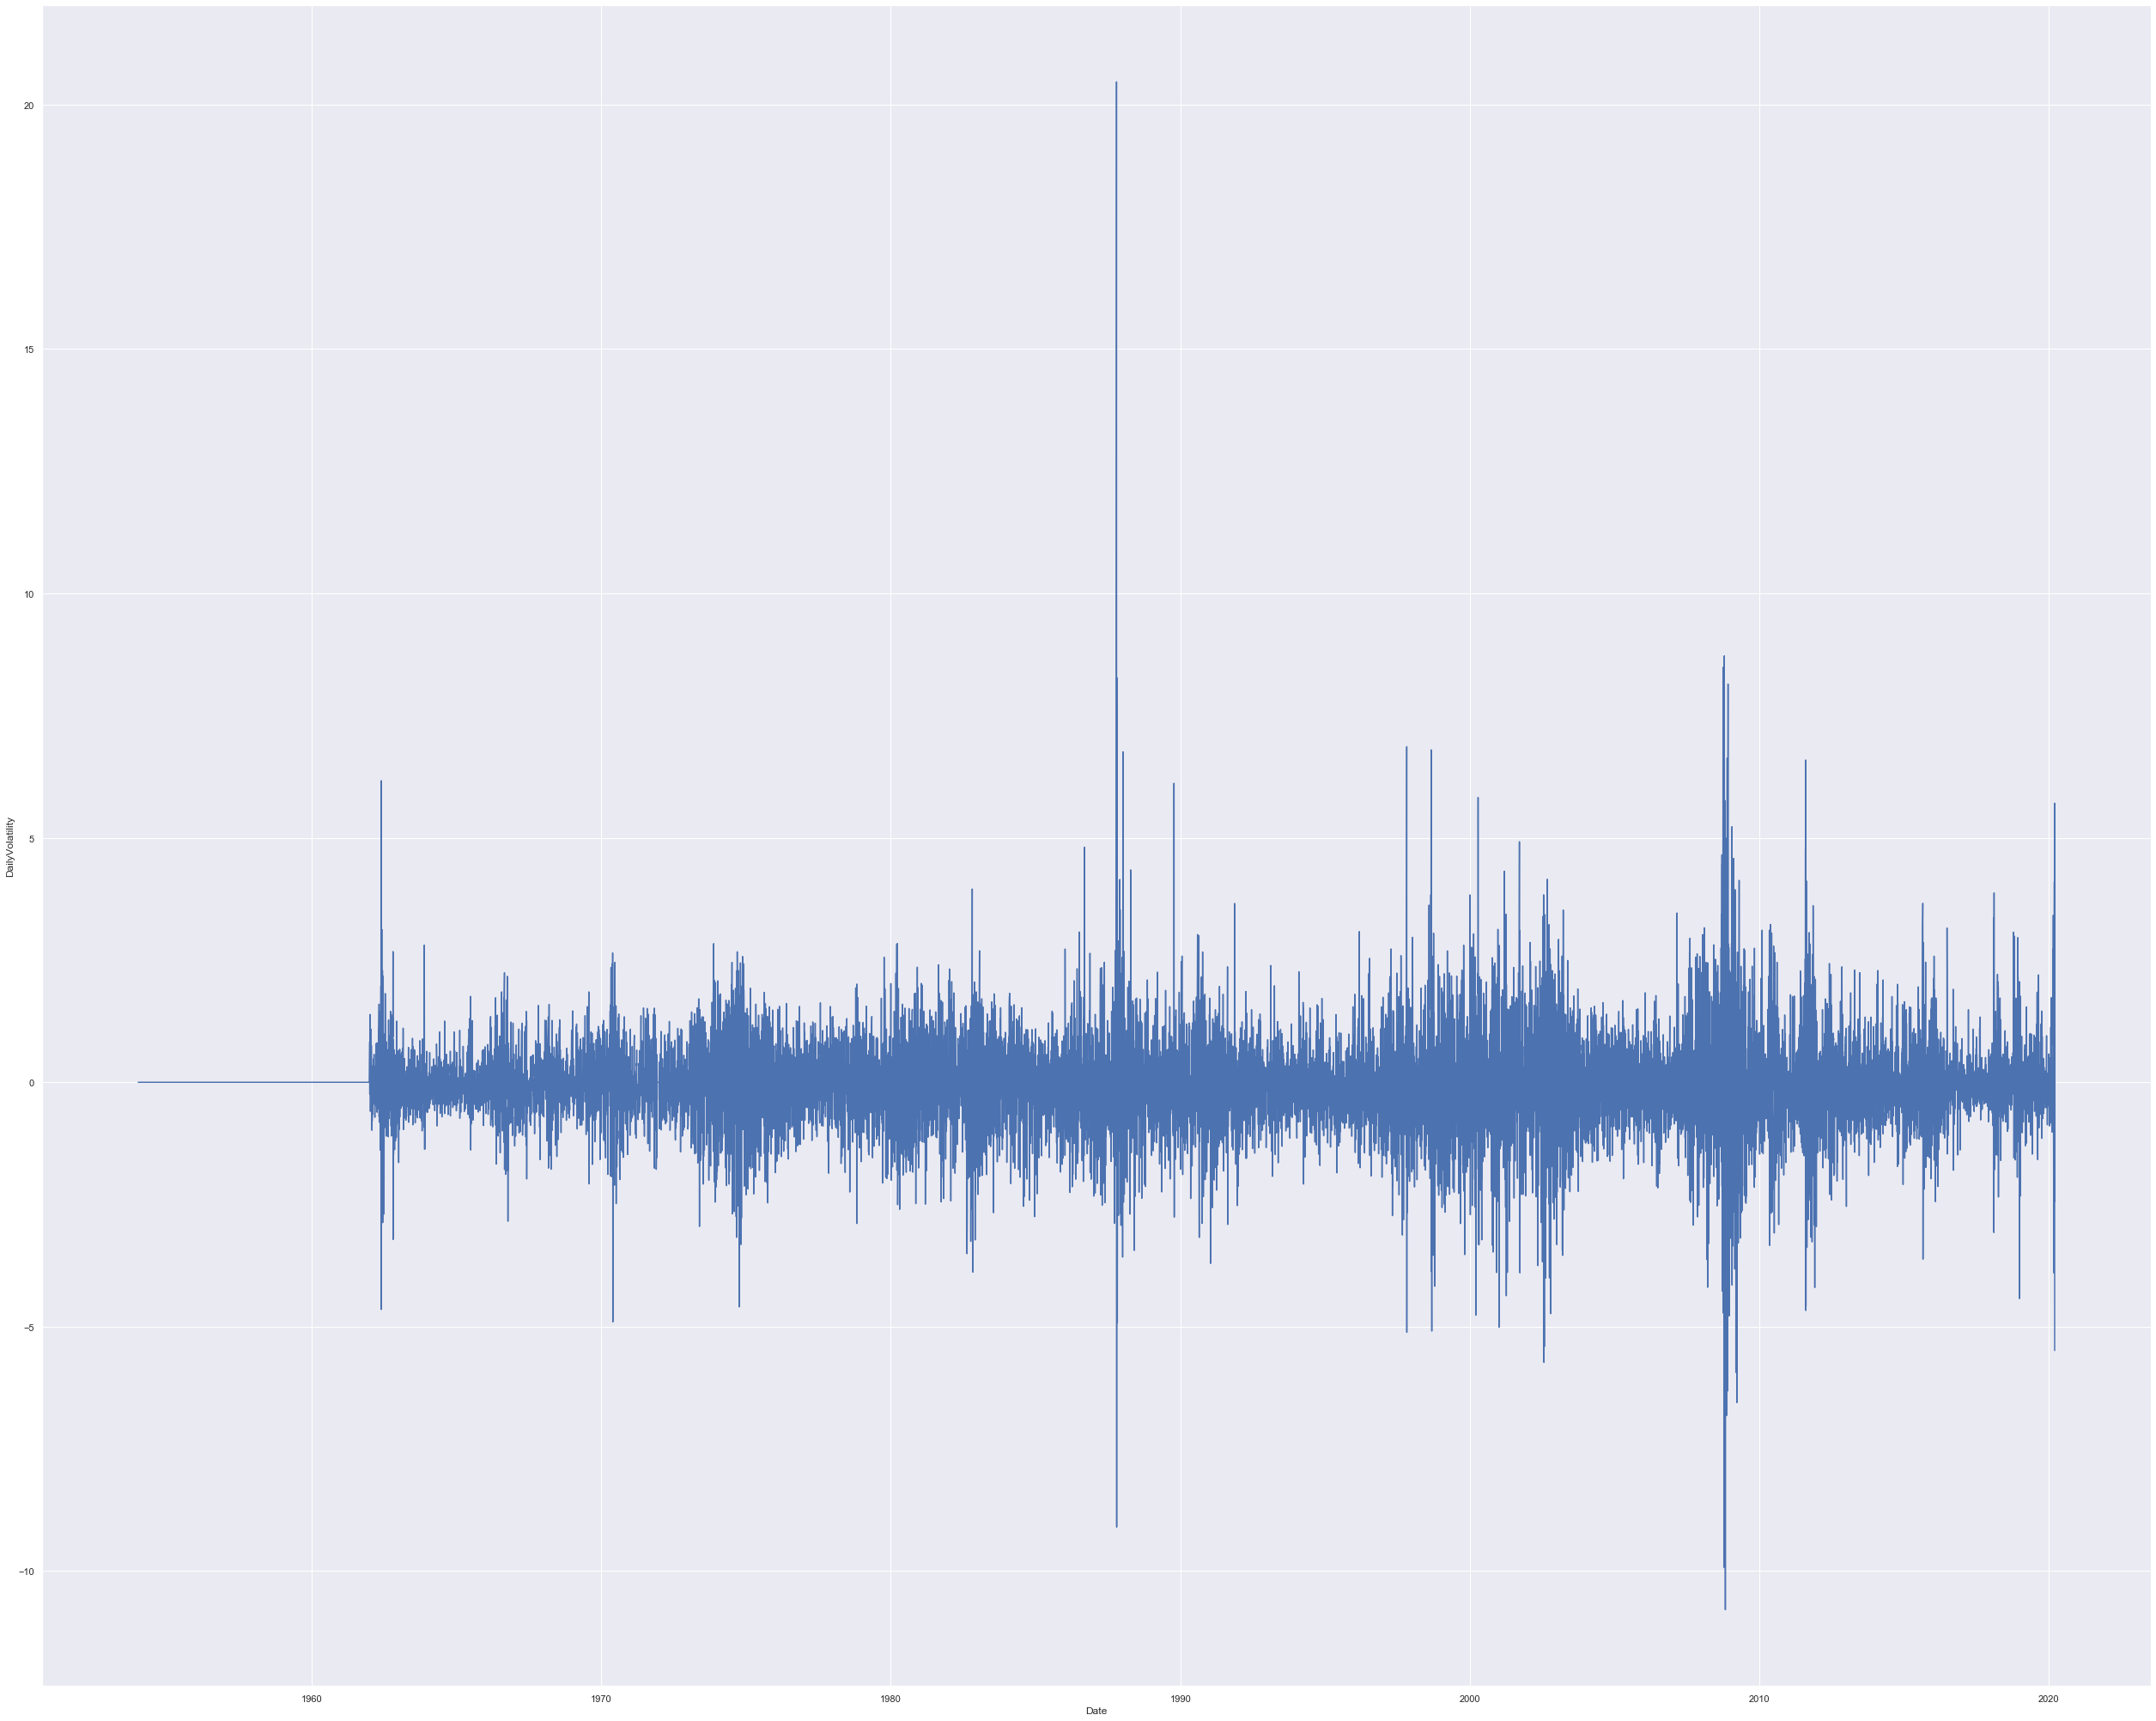

In [105]:
sns.lineplot(x='Date', y='DailyVolatility', data=SP500)

In [91]:
vertical_lines_hold = fed_funds_data[fed_funds_data['Sentiment']=='Hold']['MeetingDate']
vertical_lines_dove = fed_funds_data[fed_funds_data['Sentiment']=='Doveish']['MeetingDate']
vertical_lines_hawk = fed_funds_data[fed_funds_data['Sentiment']=='Hawkish']['MeetingDate']
vertical_lines_hold_hawk = fed_funds_data[fed_funds_data['Sentiment']=='Hold-Hawkish']['MeetingDate']
vertical_lines_hold_dove = fed_funds_data[fed_funds_data['Sentiment']=='Hold-Doveish']['MeetingDate']

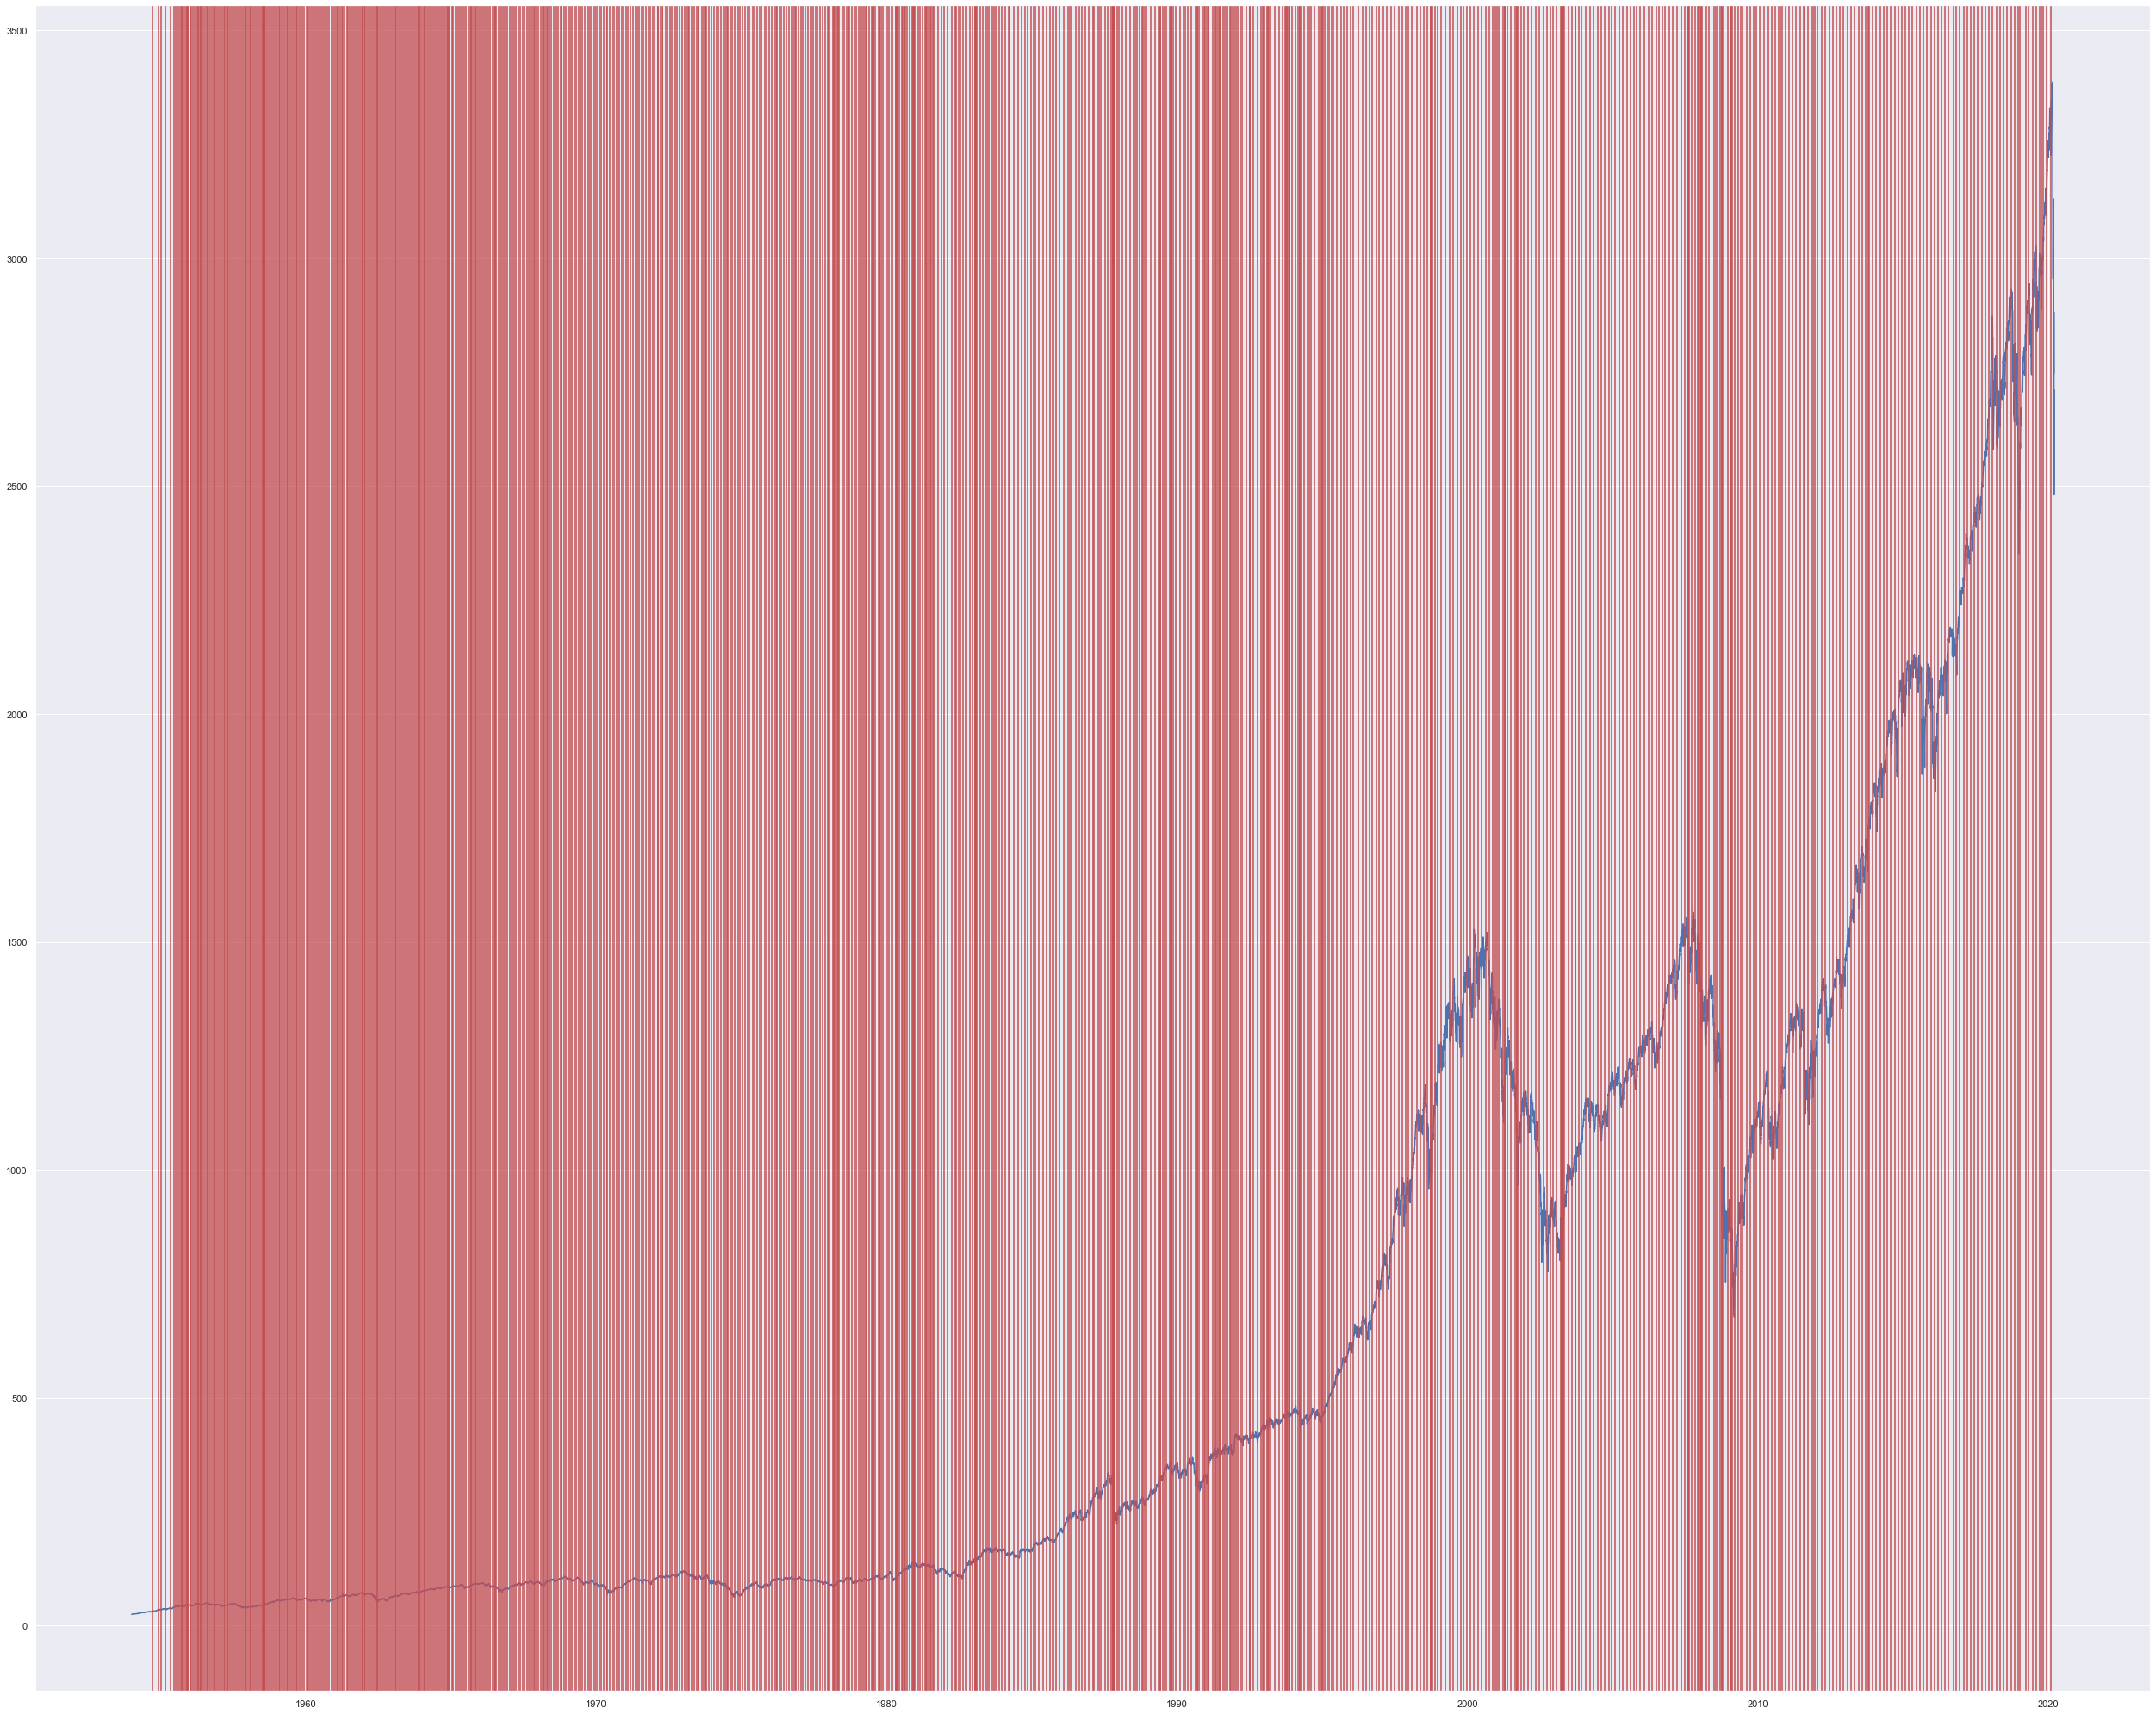

In [89]:
#ax1.axvline(pd.to_datetime('2020-01-01'),color='k', linestyle='--')
plt.plot(SP500['Date'],SP500['Close'])
for date in vertical_lines:
    plt.axvline(x=date, color='r', linestyle='-')
plt.savefig("SPY_Verticals.pdf")

In [94]:

from matplotlib.backends.backend_pdf import PdfPages

In [98]:
with PdfPages('SPY_FedFundsRate.pdf') as pdf:
    plt.plot(SP500['Date'],SP500['Close'])
    for date in vertical_lines_hold:
        plt.axvline(x=date, color='r', linestyle='-')
    plt.title('SPY Fed Decision: Hold', fontsize=36)
    pdf.savefig()  # saves the current figure into a pdf page
    plt.close()
    
    plt.plot(SP500['Date'],SP500['Close'])
    for date in vertical_lines_dove:
        plt.axvline(x=date, color='r', linestyle='-')
    plt.title('SPY Fed Decision: Doveish', fontsize=36)
    pdf.savefig()  # saves the current figure into a pdf page
    plt.close()
              
    plt.plot(SP500['Date'],SP500['Close'])
    for date in vertical_lines_hawk:
        plt.axvline(x=date, color='r', linestyle='-')
    plt.title('SPY Fed Decision: Hawkish', fontsize=36)
    pdf.savefig()  # saves the current figure into a pdf page
    plt.close()
              
    plt.plot(SP500['Date'],SP500['Close'])
    for date in vertical_lines_hold_hawk:
        plt.axvline(x=date, color='r', linestyle='-')
    plt.title('SPY Fed Decision: Hold-Hawkish', fontsize=36)
    pdf.savefig()  # saves the current figure into a pdf page
    plt.close()
              
    plt.plot(SP500['Date'],SP500['Close'])
    for date in vertical_lines_hold_dove:
        plt.axvline(x=date, color='r', linestyle='-')
    plt.title('SPY Fed Decision: Hold-Doveish', fontsize=36)
    pdf.savefig()  # saves the current figure into a pdf page
    plt.close()